# EE-UY 4563/EL-GY 9123: Introduction to machine learning
# Ernesto Akio Yoshimoto
# N12949891
# Lab #10

 # Lab:  Transfer Learning with a Pre-Trained Deep Neural Network

As we discussed earlier, state-of-the-art neural networks involve millions of parameters that are prohibitively difficult to train from scratch.  In this lab, we will illustrate a powerful technique called *fine-tuning* where we start with a large pre-trained network and then re-train only the final layers to adapt to a new task.  The method is also called *transfer learning* and can produce excellent results on very small datasets with very little computational time.  

This lab is based partially on this
[excellent blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).  In performing the lab, you will learn to:
* Build a custom image dataset
* Fine tune the final layers of an existing deep neural network for a new classification task.
* Load images with a `DataGenerator`.

The lab has two versions:
* *CPU version*:  In this version, you use lower resolution images so that the lab can be performed on your laptop.  The resulting accuracy is lower.  The code will also take considerable time to execute.
* *GPU version*:  This version uses higher resolution images but requires a GPU instance. See the [notes](../GCP/getting_started.md) on setting up a GPU instance on Google Cloud Platform.  The GPU training is much faster (< 1 minute).  

**MS students must complete the GPU version** of this lab.

## Create a Dataset

In this example, we will try to develop a classifier that can discriminate between two classes:  `cars` and `bicycles`.  One could imagine this type of classifier would be useful in vehicle vision systems.   The first task is to build a dataset.  

TODO:  Create training and test datasets with:
* 1000 training images of cars
* 1000 training images of bicylces
* 300 test images of cars
* 300 test images of bicylces
* The images don't need to be the same size.  But, you can reduce the resolution if you need to save disk space.

The images should be organized in the following directory structure:

    ./train
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0999.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0999.jpg
    ./test
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0299.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0299.jpg
           
The naming of the files within the directories does not matter.  The `ImageDataGenerator` class below will find the filenames.  Just make sure there are the correct number of files in each directory.
           
A nice automated way of building such a dataset if through the [FlickrAPI](demo08_2_flickr_images.ipynb).           
        

## Loading a Pre-Trained Deep Network

We follow the [VGG16 demo](./vgg16.ipynb) to load a pre-trained deep VGG16 network.  First, run a command to verify your instance is connected to a GPU.

In [1]:
# TODO
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10450416392589292614
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11667125044
locality {
  bus_id: 1
}
incarnation: 15678335170668403383
physical_device_desc: "device: 0, name: Tesla M40, pci bus id: 0000:03:00.0"
]


Now load the appropriate packages.

In [2]:
import tensorflow.contrib.keras

In [3]:
from tensorflow.contrib import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

Using TensorFlow backend.


We also load some standard packages.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create a Dataset

In [5]:
# Function to download images from Flickr
import flickrapi
# import urllib.request
import requests
import skimage.io
import skimage.transform

from io import BytesIO

def myDownloadImage(keyword, dir_name, nimage, nrow, ncol):
    import os  
    import warnings
    
    photos = flickr.walk(text=keyword, tag_mode='all', tags=keyword,extras='url_c',\
                     sort='relevance',per_page=100)
    dir_exists = os.path.isdir(dir_name)
    if not dir_exists:
        os.makedirs(dir_name)
        print("Making directory %s" % dir_name)
    else:
        print("Will store images in directory %s" % dir_name)
    
    i = 0
    for photo in photos:
        url=photo.get('url_c')
        if not (url is None):
            # Create a file from the URL
            # This may only work in Python3
            response = requests.get(url)
            file = BytesIO(response.content)
        
            # Read image from file
            im = skimage.io.imread(file)
        
            # Resize images
            im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant',anti_aliasing=True, anti_aliasing_sigma=None)
                
            # Convert to uint8, suppress the warning about the precision loss
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                im2 = skimage.img_as_ubyte(im1)
    
            # Save the image
            local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_name,keyword, i)  
            skimage.io.imsave(local_name, im2)      
            # print(local_name)
            i = i + 1        
        if (i >= nimage):  
            print('Finish Downloading!!')
            break    

# Download images
already_downloaded = False
if already_downloaded:
    api_key = u'45907175c467a1e968e47ab65ac17f7d'
    api_secret = u'xxxxxxxxxxxxxxxx'
    flickr = flickrapi.FlickrAPI(api_key, api_secret)

    nrow = 224
    ncol = 224  
    # Train Data:
    nimage = 1000
    keyword = 'car'
    dir_name = 'train/car'
    myDownloadImage(keyword, dir_name, nimage, nrow, ncol)
    keyword = 'bicycle'
    dir_name = 'train/bicycle'
    myDownloadImage(keyword, dir_name, nimage, nrow, ncol)
    # Test Data
    nimage = 300
    keyword = 'car'
    dir_name = 'test/car'
    myDownloadImage(keyword, dir_name, nimage, nrow, ncol)
    keyword = 'bicycle'
    dir_name = 'test/bicycle'
    myDownloadImage(keyword, dir_name, nimage, nrow, ncol)

Clear the Keras session.

In [6]:
# TODO
from keras import backend as K
# import tensorflow.python.keras.backend as K
K.clear_session()

Set the dimensions of the input image.  The sizes below would work on a GPU machine.  But, if you have a CPU image, you can use a smaller image size, like `64 x 64`.

In [7]:
# TODO:  Set to larger values if you are using a GPU.
nrow = 150
ncol = 150
# nrow = 64
# ncol = 64

Now we follow the [VGG16 demo](./vgg16.ipynb) and load the deep VGG16 network.  Alternatively, you can use any other pre-trained model in keras.  When using the `applications.VGG16` method you will need to:
* Set `include_top=False` to not include the top layer
* Set the `image_shape` based on the above dimensions.  Remember, `image_shape` should be height x width x 3 since the images are color.

In [8]:
# TODO:  Load the VGG16 network
# input_shape = ...
image_shape = [nrow, ncol, 3]
# base_model = applications.VGG16(weights='imagenet', ...)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

To create now new model, we create a Sequential model.  Then, loop over the layers in `base_model.layers` and add each layer to the new model.

In [9]:
# Create a new model
model = Sequential()

# TODO:  Loop over base_model.layers and add each layer to model
for i, layer in enumerate(base_model.layers):
    model.add(layer)
    # print(layer.trainable)

Next, loop through the layers in `model`, and freeze each layer by setting `layer.trainable = False`.  This way, you will not have to *re-train* any of the existing layers.

In [10]:
# TODO
for layer in model.layers:
    layer.trainable = False
# for i, layer in enumerate(model.layers):
    # print(layer.trainable)

Now, add the following layers to `model`:
* A `Flatten()` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 256 output units and `relu` activation
* A final fully-connected layer.  Since this is a binary classification, there should be one output and `sigmoid` activation.

In [11]:
# TODO
# model.add(...)
model.add(Flatten())
# model.add(...)
model.add(Dense(256, activation='relu'))
# ....
model.add(Dense(1, activation='sigmoid'))

Print the model summary.  This will display the number of trainable parameters vs. the non-trainable parameters.

In [12]:
# TODO
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Using Generators to Load Data

Up to now, the training data has been represented in a large matrix.  This is not possible for image data when the datasets are very large.  For these applications, the `keras` package provides a `ImageDataGenerator` class that can fetch images on the fly from a directory of images.  Using multi-threading, training can be performed on one mini-batch while the image reader can read files for the next mini-batch. The code below creates an `ImageDataGenerator` for the training data.  In addition to the reading the files, the `ImageDataGenerator` creates random deformations of the image to expand the total dataset size.  When the training data is limited, using data augmentation is very important.

In [13]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


Now, create a similar `test_generator` for the test data.

In [14]:
# TODO
# test_generator = ...
test_data_dir = './test'
# batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 600 images belonging to 2 classes.


The following function displays images that will be useful below.

In [15]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

To see how the `train_generator` works, use the `train_generator.next()` method to get a minibatch of data `X,y`.  Display the first 8 images in this mini-batch and label the image with the class label.  You should see that bicycles have `y=0` and cars have `y=1`.

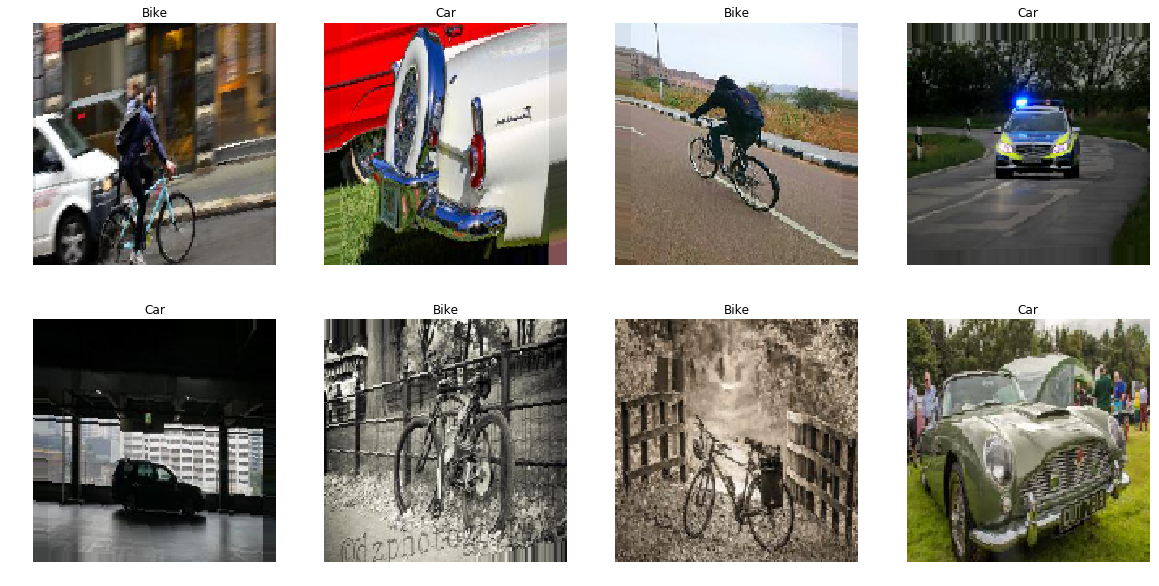

In [16]:
# TODO
X, y = train_generator.next()
plt.figure(figsize=(20,10))
for i in range(0,8):
    plt.subplot(241+i)
    plt.imshow(np.squeeze(X[i,:,:,:]))
    if y[i] == 1:
        title = 'Car'
    else:
        title = 'Bike'
    plt.title(title)
    plt.axis('off')
plt.show()

## Train the Model

Compile the model.  Select the correct `loss` function, `optimizer` and `metrics`.  Remember that we are performing binary classification.

In [17]:
# TODO.
# Optimizer learning rate
lr = 0.001
# initiate optimizer
# opt = optimizers.Adam(lr=lr)
opt = optimizers.SGD(lr=lr, momentum=0.9)
# model.compile(...)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

When using an `ImageDataGenerator`, we have to set two parameters manually:
* `steps_per_epoch =  training data size // batch_size`
* `validation_steps =  test data size // batch_size`

We can obtain the training and test data size from `train_generator.n` and `test_generator.n`, respectively.

In [18]:
# TODO
training_data_size = 2000
test_data_size = 600
steps_per_epoch =  training_data_size // batch_size
validation_steps =  test_data_size // batch_size

Now, we run the fit.  If you are using a CPU on a regular laptop, each epoch will take about 3-4 minutes, so you should be able to finish 5 epochs or so within 20 minutes.  On a reasonable GPU, even with the larger images, it will take about 10 seconds per epoch.
* If you use `(nrow,ncol) = (64,64)` images, you should get around 90% accuracy after 5 epochs.
* If you use `(nrow,ncol) = (150,150)` images, you should get around 96% accuracy after 5 epochs.  But, this will need a GPU.

You will get full credit for either version.  With more epochs, you may get slightly higher, but you will have to play with the damping.

Remember to record the history of the fit, so that you can plot the training and validation accuracy curve.

In [19]:
nepochs = 10  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 16s - loss: 0.3673 - acc: 0.8533 - val_loss: 0.2126 - val_acc: 0.9184
Epoch 2/10
62/62 [==============================] - 13s - loss: 0.1783 - acc: 0.9410 - val_loss: 0.1492 - val_acc: 0.9577
Epoch 3/10
62/62 [==============================] - 12s - loss: 0.1434 - acc: 0.9511 - val_loss: 0.1293 - val_acc: 0.9648
Epoch 4/10
62/62 [==============================] - 13s - loss: 0.1285 - acc: 0.9551 - val_loss: 0.1235 - val_acc: 0.9525
Epoch 5/10
62/62 [==============================] - 12s - loss: 0.1237 - acc: 0.9556 - val_loss: 0.1003 - val_acc: 0.9736
Epoch 6/10
62/62 [==============================] - 12s - loss: 0.1096 - acc: 0.9612 - val_loss: 0.1500 - val_acc: 0.9437
Epoch 7/10
62/62 [==============================] - 11s - loss: 0.1085 - acc: 0.9612 - val_loss: 0.1093 - val_acc: 0.9718
Epoch 8/10
62/62 [==============================] - 12s - loss: 0.1058 - acc: 0.9642 - val_loss: 0.0759 - val_acc: 0.9789
Epoch 9/10
62/62 [======

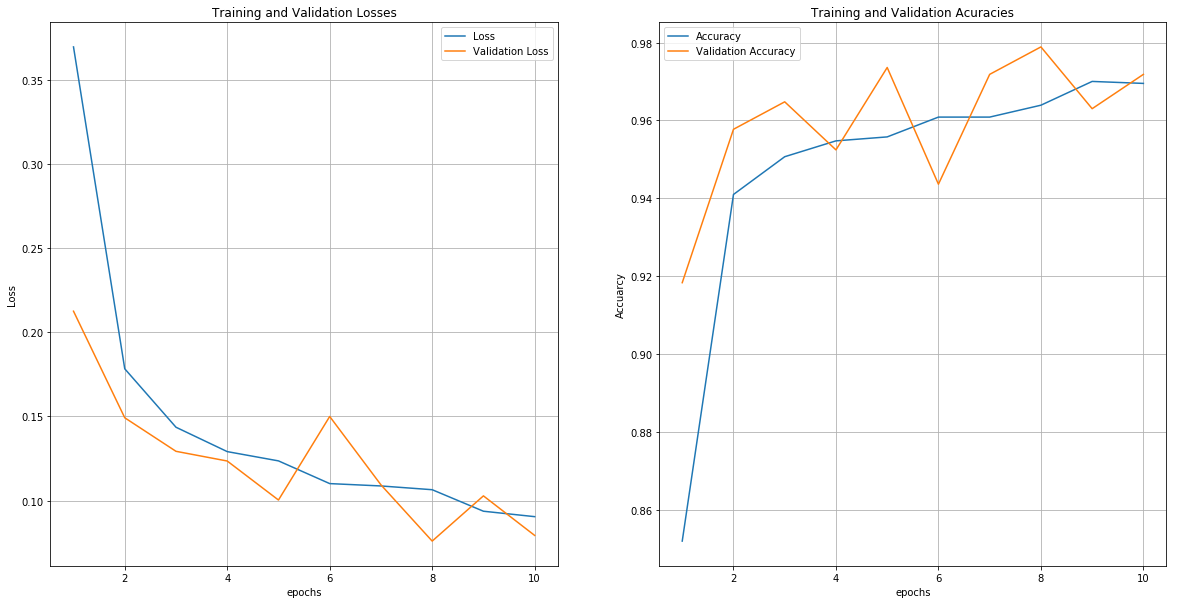

In [20]:
# Plot the training accuracy and validation accuracy curves on the same figure.
epochsn=np.arange(1,nepochs+1)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epochsn,hist.history['loss'])
plt.plot(epochsn,hist.history['val_loss'])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend(['Loss', 'Validation Loss'])
plt.subplot(1,2,2)
plt.plot(epochsn,hist.history['acc'])
plt.plot(epochsn,hist.history['val_acc'])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Accuarcy')
plt.title('Training and Validation Acuracies')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

## Evaluate your model on some test images

Apply your trained model to some specific test data and evaluate the accuracy. Also, display the test image and classified label to see whether the prediction makes sense. Note that the result depends on the test images you use. You may not get very accurate prediction for a particular minibatch. You can run this several times to see the effect on different minibatches.

*  Generate a mini-batch `Xtest,ytest` from the `test_generator.next()` method
*  Predict the labels using the `model.predict( )` method and compute predicted labels `yhat`.
*  Display the images with their ground truth labels and predicted labels 
*  Look at the images and their predicted labels, to see why the prediction is wrong in some cases.
*  If you did not get any prediction error in one minibatch, run it multiple times.


In [21]:
i = 1
while 1:
    Xtest, ytest = test_generator.next()
    yhat = model.predict(Xtest)
    yhat[yhat>0.5] = 1.
    yhat[yhat<=0.5] = 0.
    if np.sum(np.abs(yhat.T-ytest)):
        break
    i += 1
print('Iteration: %d' % i)
print('Number of errors: %d' % np.sum(np.abs(yhat.T-ytest)))


Iteration: 4
Number of errors: 1


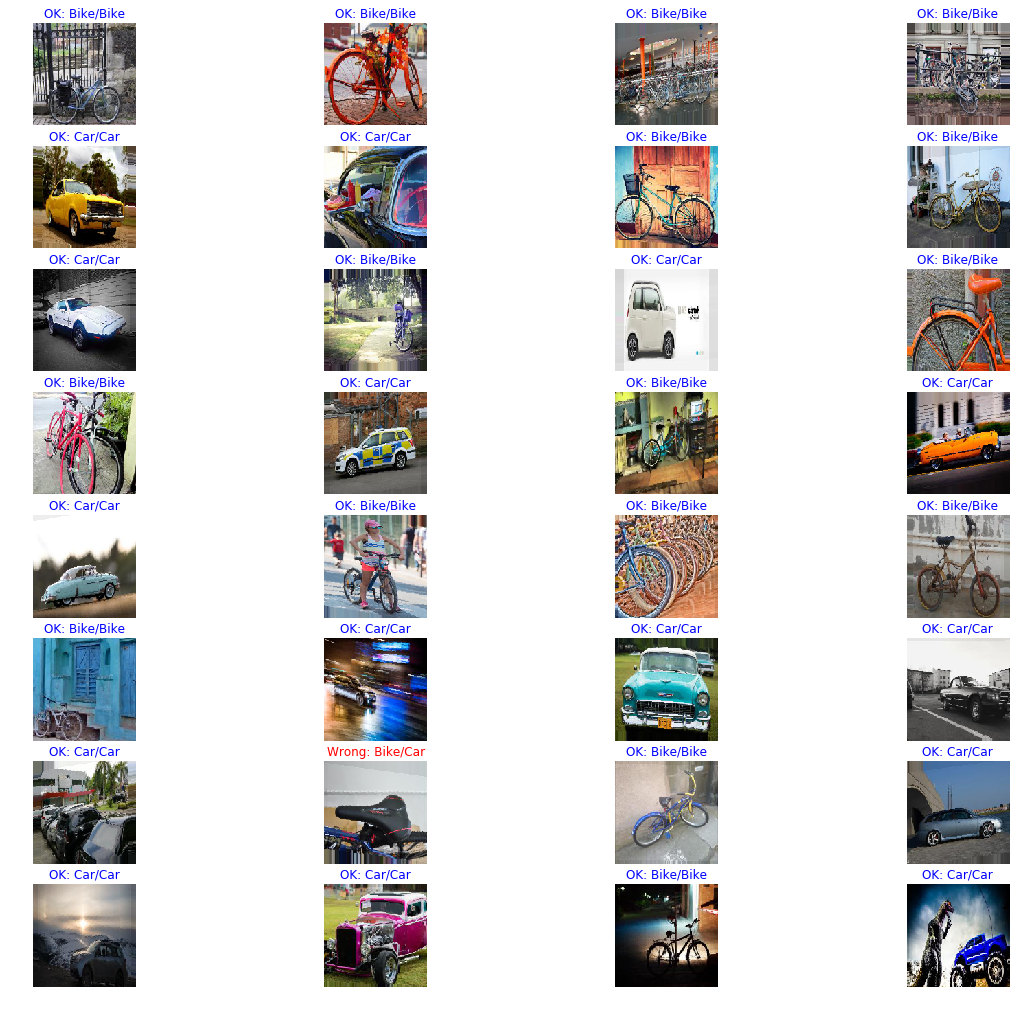

In [22]:
plt.figure(figsize=(20,20))
hsize = 4
vsize = batch_size//hsize + 1
# vsize = 4
for i in range(0,batch_size):
    plt.subplot(vsize, hsize, i+1)
    plt.imshow(np.squeeze(Xtest[i,:,:,:]))
    if ytest[i] == 1:
        title1 = 'Car'
    else:
        title1 = 'Bike'
    if yhat[i] == 1:
        title2 = 'Car'
    else:
        title2 = 'Bike'
    if title1 != title2:
        name = 'Wrong: '
        color = 'r'
    else:
        name = 'OK: '
        color = 'b'
    plt.title(name + title1 + '/' + title2, color = color)
    plt.axis('off')
plt.show()

## Train the model with Batch Normalization and Dropout
Repeat the previous process with batch normalization and dropout for training. 

Make sure that you clear the session and name your model with a different name, so that it will not continue to train from the previous model, and you can plot the performance of this model separately.


In [24]:
# TO DO
from keras.layers import BatchNormalization
# Set up the model and fit
# TO DO
K.clear_session()
base_model2 = applications.VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
# model_batch = create_mod()
# Create a new model
model_batch = Sequential()
# TODO:  Loop over base_model.layers and add each layer to model
for i, layer in enumerate(base_model2.layers):
    layer.trainable = False
    model_batch.add(layer)
#     print(i, layer.name)
    if i == 3:
        model_batch.add(BatchNormalization(name='block1_BN'))
        model_batch.add(Dropout(0.5, name='block1_DO'))
    if i == 6:
        model_batch.add(BatchNormalization(name='block2_BN'))
        model_batch.add(Dropout(0.5, name='block2_DO'))
    if i == 10:
        model_batch.add(BatchNormalization(name='block3_BN'))
        model_batch.add(Dropout(0.5, name='block3_DO'))
    if i == 14:
        model_batch.add(BatchNormalization(name='block4_BN'))
        model_batch.add(Dropout(0.5, name='block4_DO'))
# TODO
# for layer in model_batch.layers:
#     layer.trainable = False
# TODO
# model.add(...)
model_batch.add(Flatten())
model_batch.add(BatchNormalization())
model_batch.add(Dropout(0.5))
# model.add(...)
model_batch.add(Dense(256, activation='relu'))
model_batch.add(BatchNormalization())
model_batch.add(Dropout(0.5))
# ....
model_batch.add(Dense(1, activation='sigmoid'))

# TODO
print(model_batch.summary())
# initiate Adam optimizer
opt_batch = optimizers.Adam(lr=lr)
# model.compile(...)
model_batch.compile(loss='binary_crossentropy',
              optimizer=opt_batch,
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block1_BN (BatchNormalizatio (None, 75, 75, 64)        256       
_________________________________________________________________
block1_DO (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
__________

In [25]:
# Model fit
# TO DO
hist_batch = model_batch.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 17s - loss: 0.3398 - acc: 0.8977 - val_loss: 0.3154 - val_acc: 0.8327
Epoch 2/10
62/62 [==============================] - 15s - loss: 0.1987 - acc: 0.9204 - val_loss: 0.1385 - val_acc: 0.9595
Epoch 3/10
62/62 [==============================] - 15s - loss: 0.1384 - acc: 0.9481 - val_loss: 0.0760 - val_acc: 0.9789
Epoch 4/10
62/62 [==============================] - 16s - loss: 0.1446 - acc: 0.9501 - val_loss: 0.0652 - val_acc: 0.9824
Epoch 5/10
62/62 [==============================] - 15s - loss: 0.1105 - acc: 0.9566 - val_loss: 0.0394 - val_acc: 0.9930
Epoch 6/10
62/62 [==============================] - 15s - loss: 0.1027 - acc: 0.9612 - val_loss: 0.0326 - val_acc: 0.9930
Epoch 7/10
62/62 [==============================] - 15s - loss: 0.1226 - acc: 0.9536 - val_loss: 0.0308 - val_acc: 0.9930
Epoch 8/10
62/62 [==============================] - 15s - loss: 0.1017 - acc: 0.9572 - val_loss: 0.0238 - val_acc: 0.9947
Epoch 9/10
62/62 [======

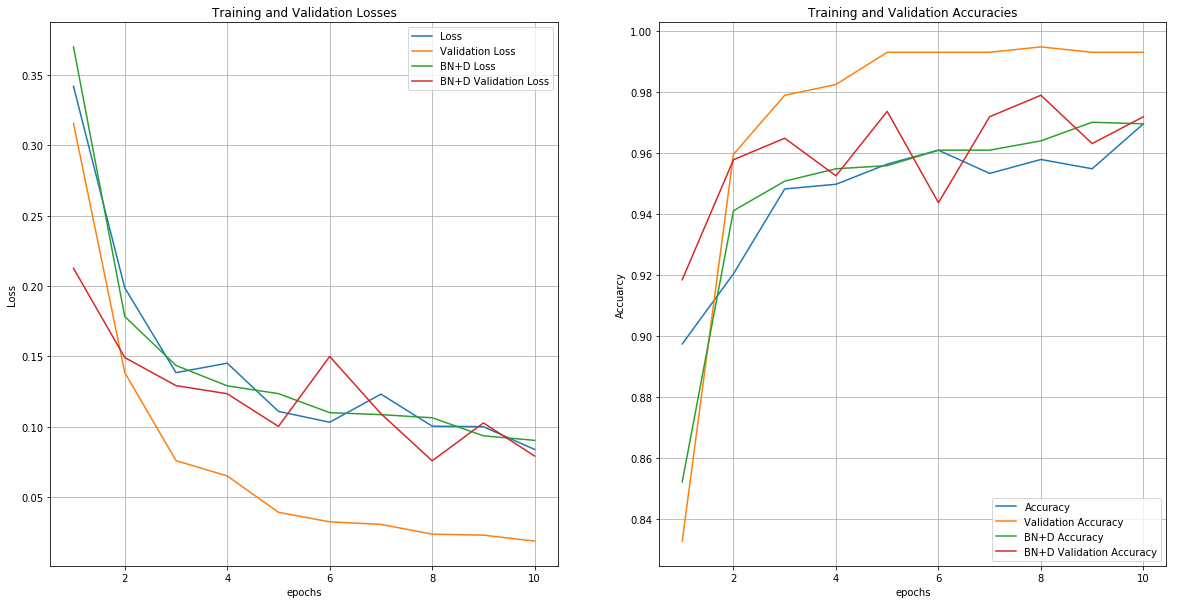

In [26]:
# Plot the training performance
# TO DO
epochsn=np.arange(1,nepochs+1)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epochsn,hist_batch.history['loss'])
plt.plot(epochsn,hist_batch.history['val_loss'])
plt.plot(epochsn,hist.history['loss'])
plt.plot(epochsn,hist.history['val_loss'])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend(['Loss', 'Validation Loss','BN+D Loss', 'BN+D Validation Loss'])
plt.subplot(1,2,2)
plt.plot(epochsn,hist_batch.history['acc'])
plt.plot(epochsn,hist_batch.history['val_acc'])
plt.plot(epochsn,hist.history['acc'])
plt.plot(epochsn,hist.history['val_acc'])
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Accuarcy')
plt.title('Training and Validation Accuracies')
plt.legend(['Accuracy', 'Validation Accuracy','BN+D Accuracy', 'BN+D Validation Accuracy'])
plt.show()

Question:  Observe the difference in the training and validation accuracy curves with and without using batch normalization and dropout. Are the results as expected? Explain.

Answer:
- Training accuracy is lower than the training validation accuracy with and without batch normalization and dropout. This is not ussual, but it can happen because we are ussing a pretrained scheame and only training the flat layers of the model.
